<a href="https://colab.research.google.com/github/OD1992/Python-programs/blob/main/Poisson_malaria_model_CI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
import warnings
import pandas as pd
import statsmodels.api as sm
from statsmodels.genmod.families import Gaussian, Gamma, Poisson
from statsmodels.genmod.families.links import identity, log, sqrt
#!pip install PyMC3
import pymc3 as pm
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.5


In [21]:

bd_url1 ='/Dakar.csv'
df = pd.read_csv(bd_url1, header=0, infer_datetime_format=False, parse_dates=[0])

#***************************************************************************************************
#Defined the avaerage temperature
AVT_Dakar=(df.Tempmin_Dakar + df.Tempmax_Dakar)/2
AVT_Fatick=(df.Tempmin_Fatick + df.Tempmax_Fatick)/2
AVT_Kedougou=(df.Tempmin_Kedougou + df.Tempmax_Kedougou)/2

warnings.filterwarnings("ignore") 

ERROR:pymc3:There were 264 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1150 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


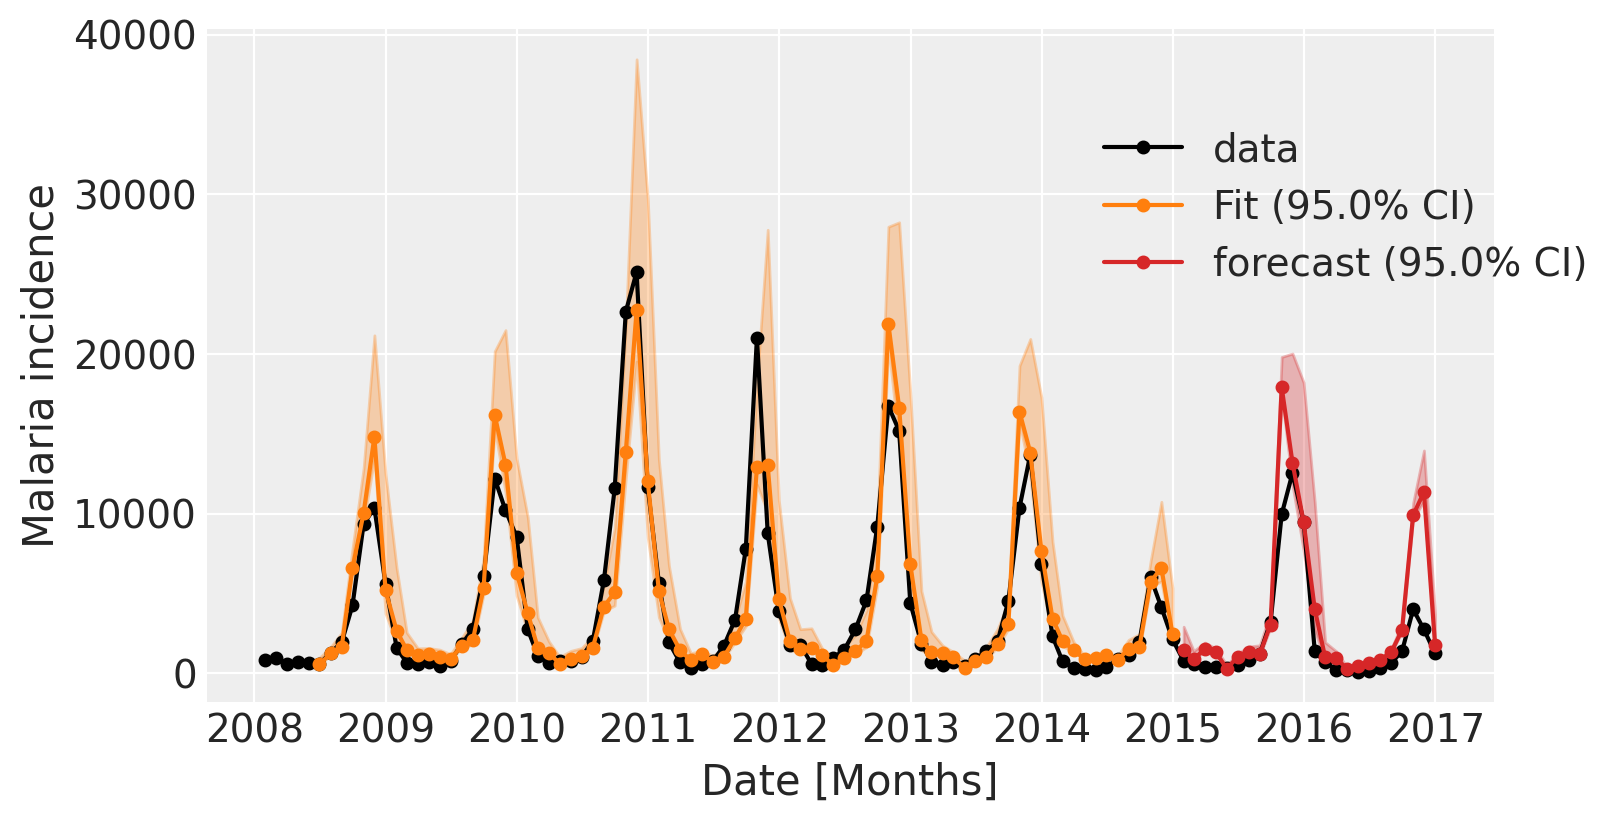

In [22]:
#************************ Dakar ******************************
#******************** We take into account the lag *************************
t_s=0;t_i=5; t_c=84; t_e=108; intercept=np.ones(t_e) 
X = np.c_[df.Rainfall, AVT_Dakar, df.Humidity_D, df.MC_Dakar, intercept]
y_o=df.MC_Dakar.values; lag=[2,2,5,1] 
y_train=y_o[t_i:t_c] ; y_test=y_o[t_c:t_e]
X_train = np.c_[X[t_i-lag[0]:t_c-lag[0],0], X[t_i-lag[1]:t_c-lag[1],1], X[t_i-lag[2]:t_c-lag[2],2], X[t_i-lag[3]:t_c-lag[3],3], X[t_i:t_c,4]]
X_test = np.c_[X[t_c-lag[0]:t_e-lag[0],0], X[t_c-lag[1]:t_e-lag[1],1], X[t_c-lag[2]:t_e-lag[2],2], X[t_c-lag[3]:t_e-lag[3],3], X[t_c:t_e,4]]
model = sm.GLM(y_train, X_train, family=Poisson(link=identity)).fit()     
ecart_type = np.sqrt(np.diag(model.cov_params()))
# True parameter values
alpha = model.params[4];   beta = [model.params[0], model.params[1], model.params[2], model.params[3]]
# Predictor variable
X0 = X_train[:,0]; X1 = X_train[:,1]; X2 = X_train[:,2]; X3 = X_train[:,3]
# Simulate outcome variable
Y = alpha + beta[0] * X0 + beta[1] * X1 + beta[2] * X2 + beta[3] * X3
basic_model = pm.Model()
with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=model.params[4], sigma=ecart_type[4]**2)
    beta[0] = pm.Normal("beta[0]", mu=model.params[0], sigma=ecart_type[0]**2) #np.abs(model.params[0])**2
    beta[1] = pm.Normal("beta[1]", mu=model.params[1], sigma=ecart_type[1]**2)
    beta[2] = pm.Normal("beta[2]", mu=model.params[2], sigma=ecart_type[2]**2)
    beta[3] = pm.Normal("beta[3]", mu=model.params[3], sigma=ecart_type[3]**2)
    #****  Deterministic model of the expected and the forecasted value of outcome
    mu = alpha + beta[0] * X0 + beta[1] * X1 + beta[2] * X2 + beta[3] * X3
    #*****Posterior distribution   
    pm.Poisson("Obs", mu=mu, observed=y_train)
    pm.Deterministic('mu', mu)

    forecasts = beta[0]*X_test[:,0] + beta[1] * X_test[:,1] + beta[2] * X_test[:,2] + beta[3] * X_test[:,3] + alpha
    pm.StudentT("obss",nu=4, mu=forecasts, sigma=forecasts ** 0.5 ,observed=y_test)
    pm.Deterministic('forecasts', forecasts)
    #****we use Powell’s method to find the MAP
    map_estimate = pm.find_MAP(model=basic_model, method="powell")
    #print(sw_regions, sw_model, map_estimate)
    #*******posterior samples
    trace = pm.sample(draws=8000,tune=300)  #
    #trace["alpha"] #We can see the  values for the alpha variable as follows:
    q_1 =2.5; q_3 =97.5
    fig=plt.figure(figsize=(8,4))
    plt.plot(df.Date, y_o, label='data',color = "black" , marker='o', markersize=4)
    percentiles = np.percentile(trace.mu, q_1, axis=0), np.percentile(trace.mu, q_3, axis=0)
    percentiles_forecasts = np.percentile(trace.forecasts, q_1, axis=0), np.percentile(trace.forecasts, q_3, axis=0)
    plt.plot(df.Date[t_i:t_c], np.median(trace.mu, axis=0),color='tab:orange', label='Fit ('+str(q_3 - q_1) + '% CI)',  marker='o', markersize=4)
    plt.plot(df.Date[t_c:t_e], np.median(trace.forecasts, axis=0),color='tab:red', label='forecast ('+str(q_3 - q_1) + '% CI)',  marker='o', markersize=4)
    plt.fill_between(df.Date[t_i:t_c], percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')
    plt.fill_between(df.Date[t_c:t_e], percentiles_forecasts[0], percentiles_forecasts[1], alpha=0.3, color='tab:red')
    #plt.yscale('log')
    plt.ylabel('Malaria incidence')
    plt.xlabel('Date [Months]')
    #plt.xticks(rotation=90)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 0.9), shadow=True, ncol=1)
    plt.show()

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6f33251250>,
      dtype=object)

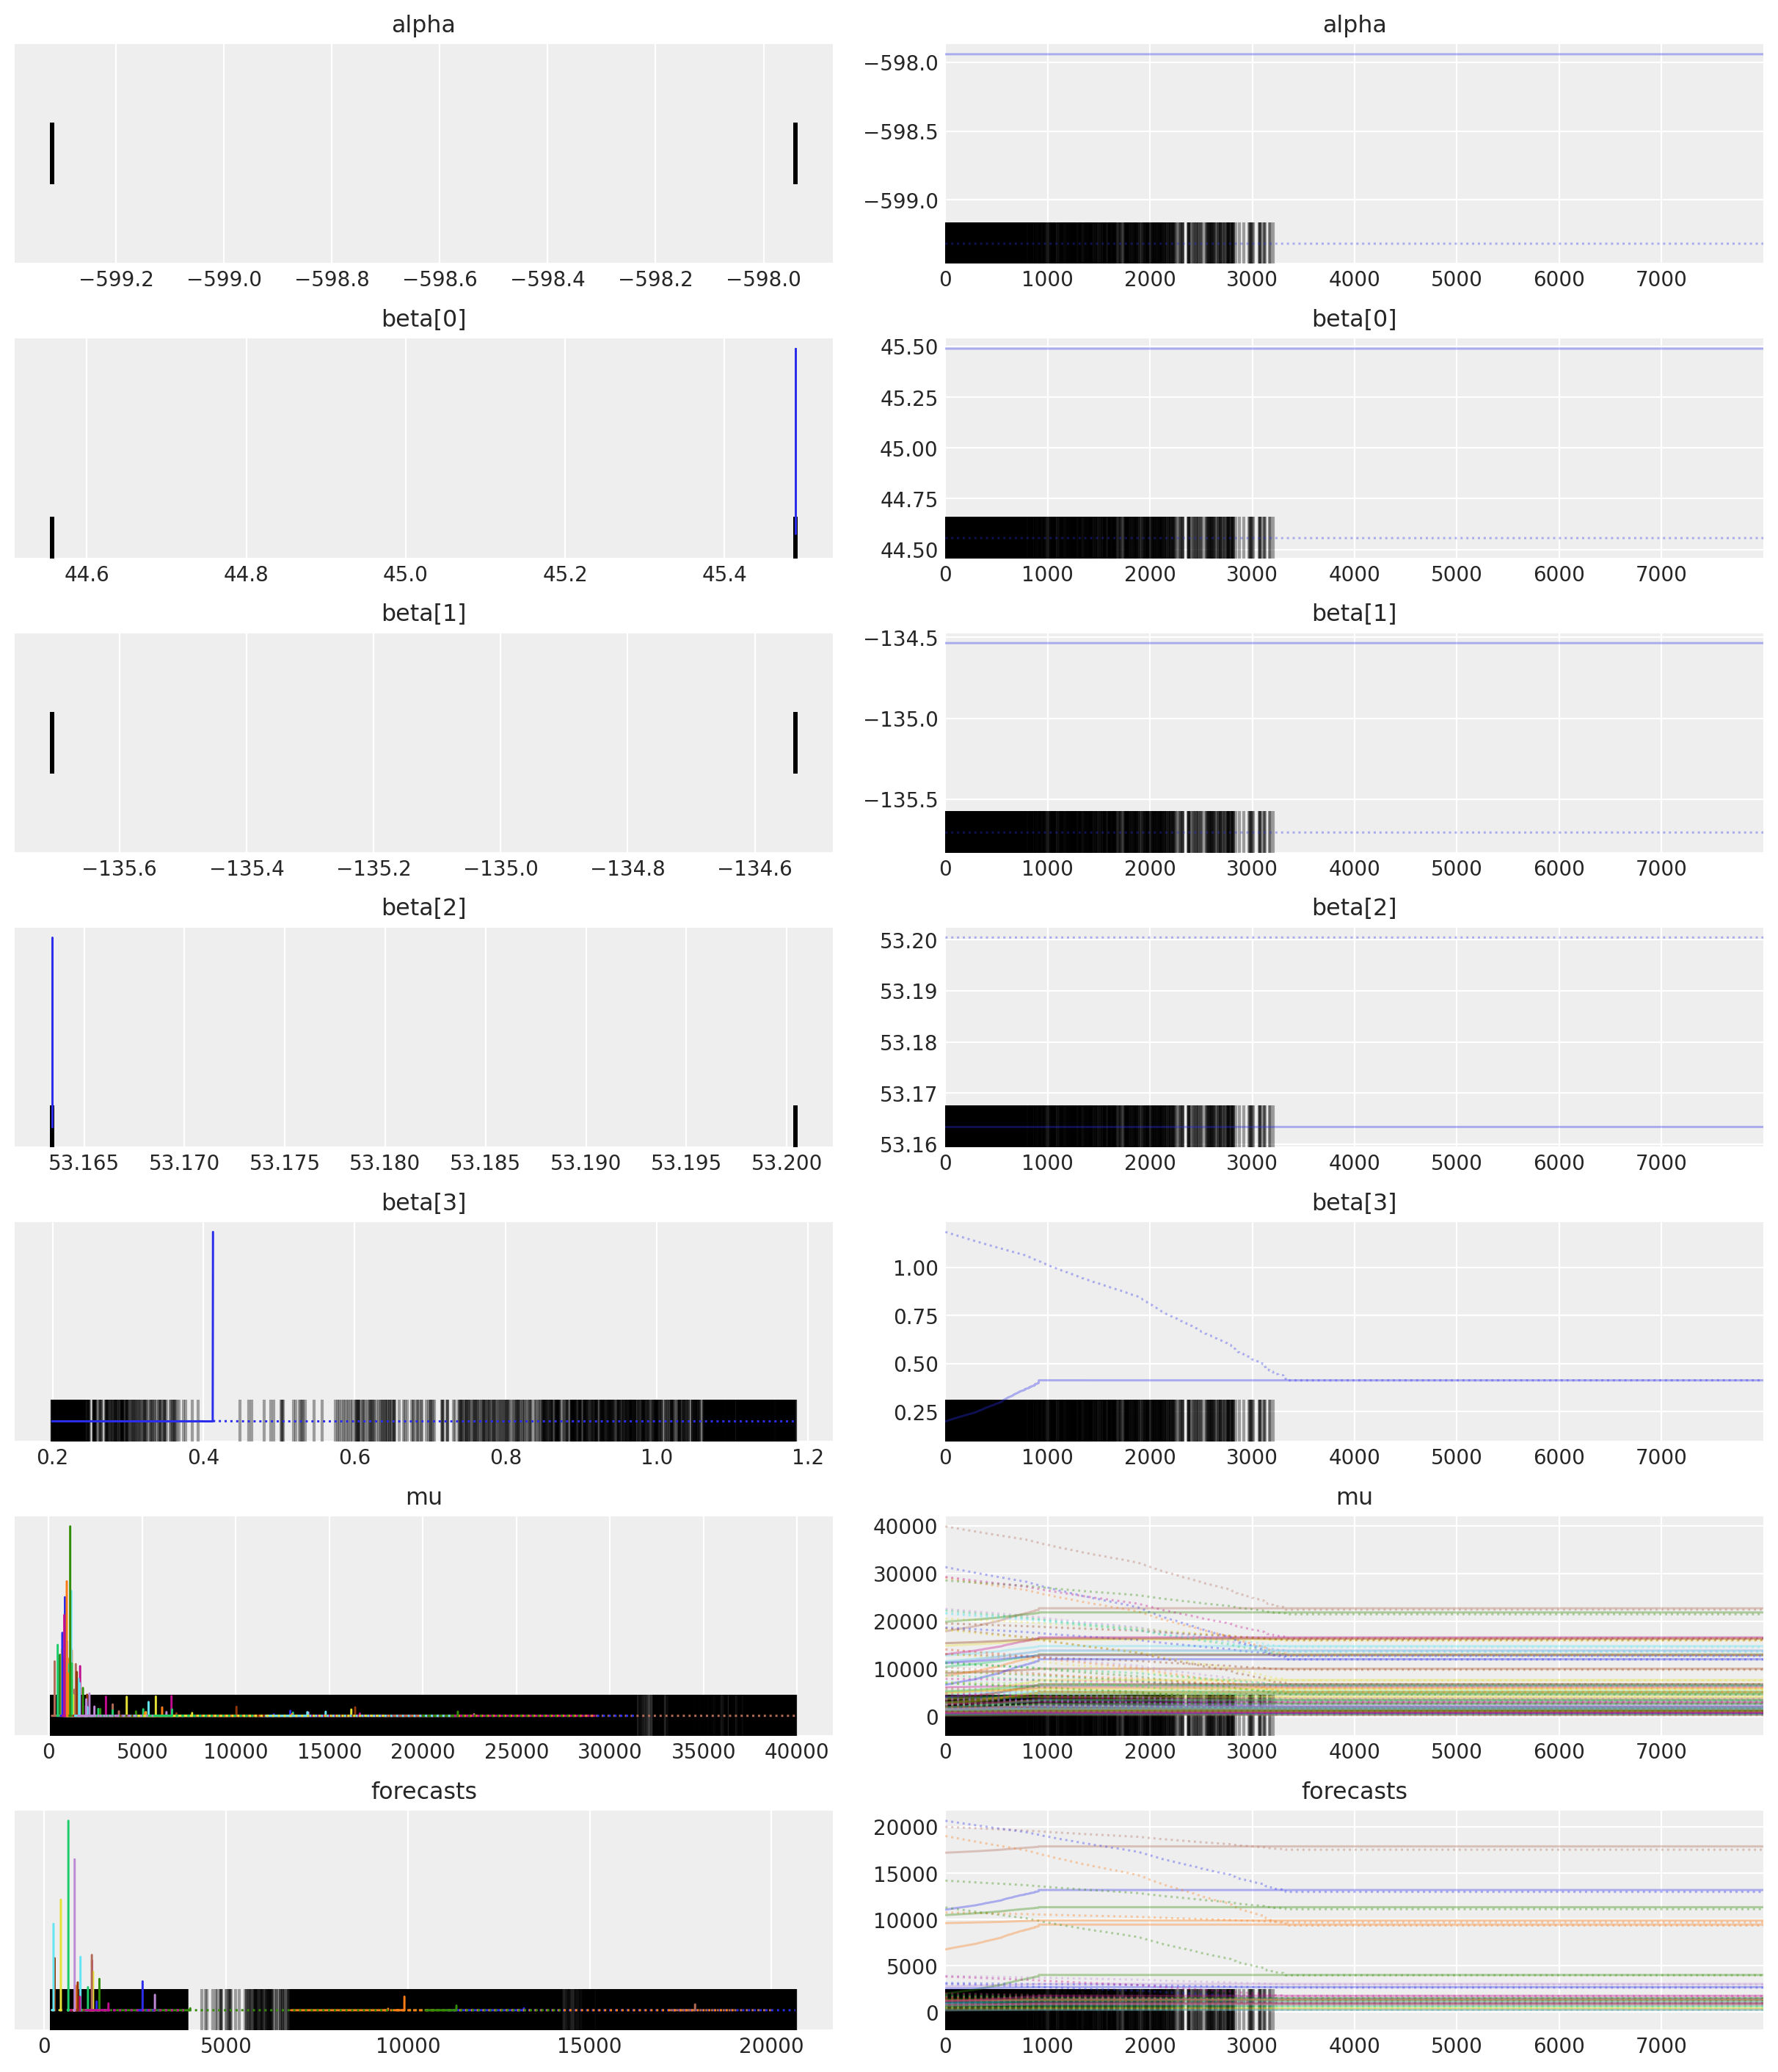

In [24]:
#from pymc3 import trace

pm.traceplot(trace)

ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


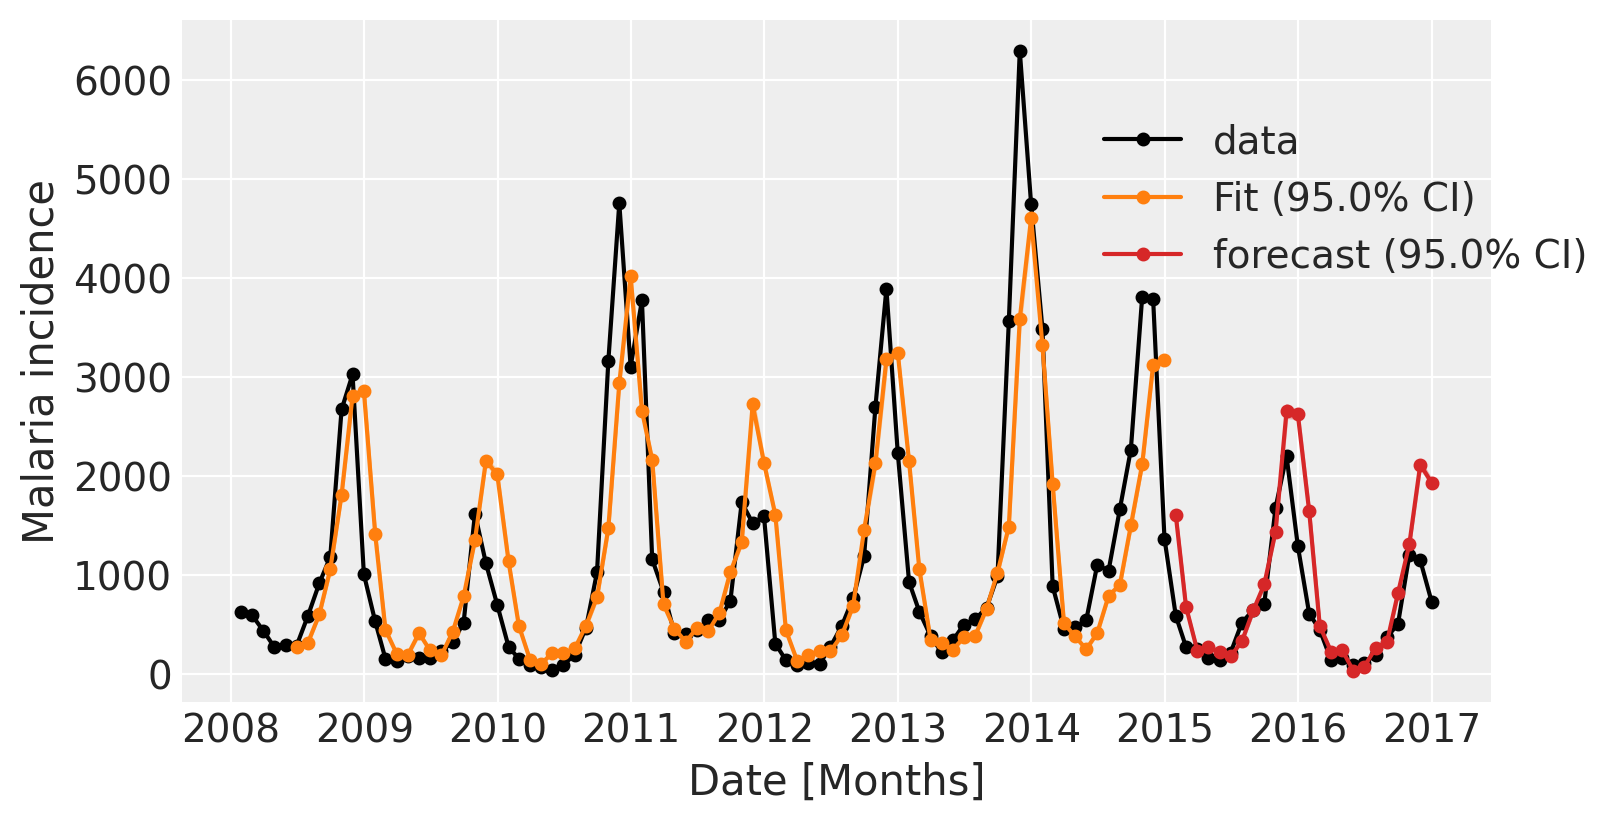

In [12]:
#************************ Fatick ******************************
#******************** We take into account the lag *************************
t_s=0;t_i=5; t_c=84; t_e=108; intercept=np.ones(t_e) 
X = np.c_[df.Rainfall_F, AVT_Fatick, df.Humidity_F, df.MC_Fatick, intercept]
y_o=df.MC_Fatick.values; lag=[3,4,3,1]
y_train=y_o[t_i:t_c] ; y_test=y_o[t_c:t_e]
X_train = np.c_[X[t_i-lag[0]:t_c-lag[0],0], X[t_i-lag[1]:t_c-lag[1],1], X[t_i-lag[2]:t_c-lag[2],2], X[t_i-lag[3]:t_c-lag[3],3], X[t_i:t_c,4]]
X_test = np.c_[X[t_c-lag[0]:t_e-lag[0],0], X[t_c-lag[1]:t_e-lag[1],1], X[t_c-lag[2]:t_e-lag[2],2], X[t_c-lag[3]:t_e-lag[3],3], X[t_c:t_e,4]]
model = sm.GLM(y_train, X_train, family=Poisson(link=identity)).fit()     
ecart_type = np.sqrt(np.diag(model.cov_params()))
# True parameter values
alpha = model.params[4];  beta = [model.params[0], model.params[1], model.params[2], model.params[3]]
# Predictor variable
X0 = X_train[:,0]; X1 = X_train[:,1]; X2 = X_train[:,2]; X3 = X_train[:,3]
# Simulate outcome variable
Y = alpha + beta[0] * X0 + beta[1] * X1 + beta[2] * X2 + beta[3] * X3
basic_model = pm.Model()
with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=model.params[4], sigma=ecart_type[4]**2)
    beta[0] = pm.Normal("beta[0]", mu=model.params[0], sigma=ecart_type[0]**2) #np.abs(model.params[0])**2
    beta[1] = pm.Normal("beta[1]", mu=model.params[1], sigma=ecart_type[1]**2)
    beta[2] = pm.Normal("beta[2]", mu=model.params[2], sigma=ecart_type[2]**2)
    beta[3] = pm.Normal("beta[3]", mu=model.params[3], sigma=ecart_type[3]**2)
    #****  Deterministic model of the expected and the forecasted value of outcome
    mu = alpha + beta[0] * X0 + beta[1] * X1 + beta[2] * X2 + beta[3] * X3
    #*****Posterior distribution   
    pm.Poisson("Obs", mu=mu, observed=y_train)
    pm.Deterministic('mu', mu)
    forecasts = beta[0]*X_test[:,0] + beta[1] * X_test[:,1] + beta[2] * X_test[:,2] + beta[3] * X_test[:,3] + alpha
    pm.StudentT("obss",nu=4, mu=forecasts, sigma=forecasts ** 0.5 ,observed=y_test)
    pm.Deterministic('forecasts', forecasts)
    #*******posterior samples
    trace = pm.sample(draws=8000,tune=300)  #
    #trace["alpha"] #We can see the  values for the alpha variable as follows:
    q_1 =2.5; q_3 =97.5
    fig=plt.figure(figsize=(8,4))
    plt.plot(df.Date, y_o, label='data',color = "black" , marker='o', markersize=4)
    percentiles = np.percentile(trace.mu, q_1, axis=0), np.percentile(trace.mu, q_3, axis=0)
    percentiles_forecasts = np.percentile(trace.forecasts, q_1, axis=0), np.percentile(trace.forecasts, q_3, axis=0)
    plt.plot(df.Date[t_i:t_c], np.median(trace.mu, axis=0),color='tab:orange', label='Fit ('+str(q_3 - q_1) + '% CI)',  marker='o', markersize=4)
    plt.plot(df.Date[t_c:t_e], np.median(trace.forecasts, axis=0),color='tab:red', label='forecast ('+str(q_3 - q_1) + '% CI)',  marker='o', markersize=4)
    plt.fill_between(df.Date[t_i:t_c], percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')
    plt.fill_between(df.Date[t_c:t_e], percentiles_forecasts[0], percentiles_forecasts[1], alpha=0.3, color='tab:red')
    plt.ylabel('Malaria incidence')
    plt.xlabel('Date [Months]')
    #plt.xticks(rotation=90)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 0.9), shadow=True, ncol=1)
    plt.show()

ERROR:pymc3:There were 421 divergences after tuning. Increase `target_accept` or reparameterize.


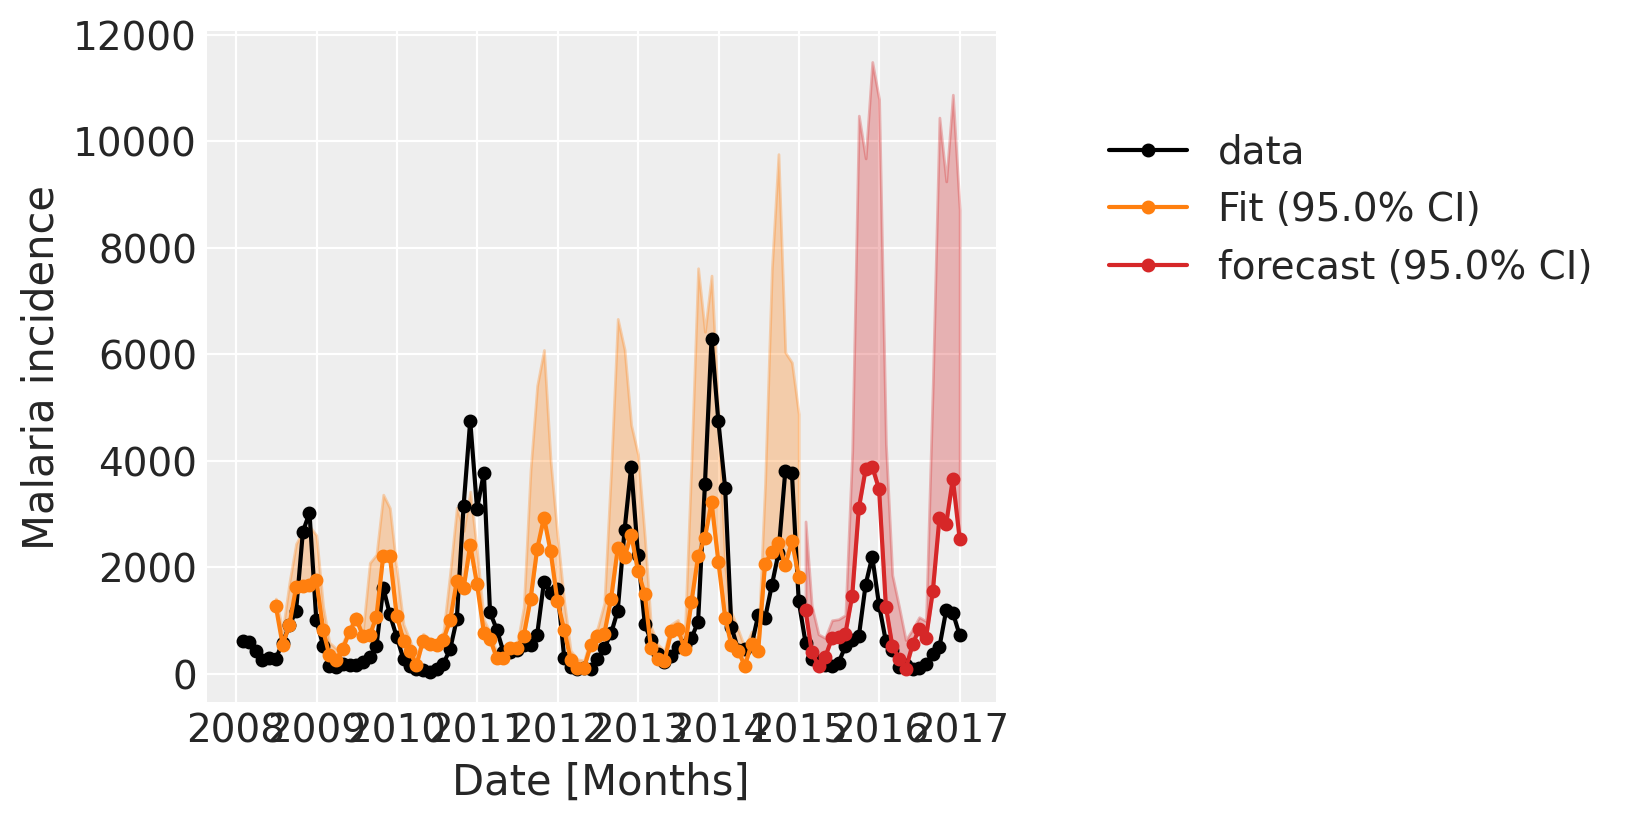

In [13]:
#************************ Kedougou ******************************
#******************** We take into account the lag *************************
t_s=0;t_i=5; t_c=84; t_e=108; intercept=np.ones(t_e) 
X = np.c_[df.Rainfall_K, AVT_Kedougou, df.Humidity_K, df.MC_Kedougou, intercept]
y_o=df.MC_Fatick.values; lag = [2,5,2,1]
y_train=y_o[t_i:t_c] ; y_test=y_o[t_c:t_e]
X_train = np.c_[X[t_i-lag[0]:t_c-lag[0],0], X[t_i-lag[1]:t_c-lag[1],1], X[t_i-lag[2]:t_c-lag[2],2], X[t_i-lag[3]:t_c-lag[3],3], X[t_i:t_c,4]]
X_test = np.c_[X[t_c-lag[0]:t_e-lag[0],0], X[t_c-lag[1]:t_e-lag[1],1], X[t_c-lag[2]:t_e-lag[2],2], X[t_c-lag[3]:t_e-lag[3],3], X[t_c:t_e,4]]
model = sm.GLM(y_train, X_train, family=Poisson(link=identity)).fit()     
ecart_type = np.sqrt(np.diag(model.cov_params()))
# True parameter values
alpha = model.params[4];  beta = [model.params[0], model.params[1], model.params[2], model.params[3]]
# Predictor variable
X0 = X_train[:,0]; X1 = X_train[:,1]; X2 = X_train[:,2]; X3 = X_train[:,3]
# Simulate outcome variable
Y = alpha + beta[0] * X0 + beta[1] * X1 + beta[2] * X2 + beta[3] * X3
basic_model = pm.Model()
with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=model.params[4], sigma=ecart_type[4]**2)
    beta[0] = pm.Normal("beta[0]", mu=model.params[0], sigma=ecart_type[0]**2) #np.abs(model.params[0])**2
    beta[1] = pm.Normal("beta[1]", mu=model.params[1], sigma=ecart_type[1]**2)
    beta[2] = pm.Normal("beta[2]", mu=model.params[2], sigma=ecart_type[2]**2)
    beta[3] = pm.Normal("beta[3]", mu=model.params[3], sigma=ecart_type[3]**2)
    #****  Deterministic model of the expected and the forecasted value of outcome
    mu = alpha + beta[0] * X0 + beta[1] * X1 + beta[2] * X2 + beta[3] * X3
    #*****Posterior distribution   
    pm.Poisson("Obs", mu=mu, observed=y_train)
    pm.Deterministic('mu', mu)
    forecasts = beta[0]*X_test[:,0] + beta[1] * X_test[:,1] + beta[2] * X_test[:,2] + beta[3] * X_test[:,3] + alpha
    pm.StudentT("obss",nu=4, mu=forecasts, sigma=forecasts ** 0.5 ,observed=y_test)
    pm.Deterministic('forecasts', forecasts)
    #*******posterior samples
    trace = pm.sample(draws=8000,tune=300)  #
    #trace["alpha"] #We can see the  values for the alpha variable as follows:
    q_1 =2.5; q_3 =97.5
    fig=plt.figure(figsize=(8,4))
    plt.plot(df.Date, y_o, label='data',color = "black" , marker='o', markersize=4)
    percentiles = np.percentile(trace.mu, q_1, axis=0), np.percentile(trace.mu, q_3, axis=0)
    percentiles_forecasts = np.percentile(trace.forecasts, q_1, axis=0), np.percentile(trace.forecasts, q_3, axis=0)
    plt.plot(df.Date[t_i:t_c], np.median(trace.mu, axis=0),color='tab:orange', label='Fit ('+str(q_3 - q_1) + '% CI)',  marker='o', markersize=4)
    plt.plot(df.Date[t_c:t_e], np.median(trace.forecasts, axis=0),color='tab:red', label='forecast ('+str(q_3 - q_1) + '% CI)',  marker='o', markersize=4)
    plt.fill_between(df.Date[t_i:t_c], percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')
    plt.fill_between(df.Date[t_c:t_e], percentiles_forecasts[0], percentiles_forecasts[1], alpha=0.3, color='tab:red')
    plt.ylabel('Malaria incidence')
    plt.xlabel('Date [Months]')
    #plt.xticks(rotation=90)
    plt.legend(loc='upper left', bbox_to_anchor=(1.1, 0.9), shadow=True, ncol=1)
    plt.show()

ERROR:pymc3:There were 44 divergences after tuning. Increase `target_accept` or reparameterize.


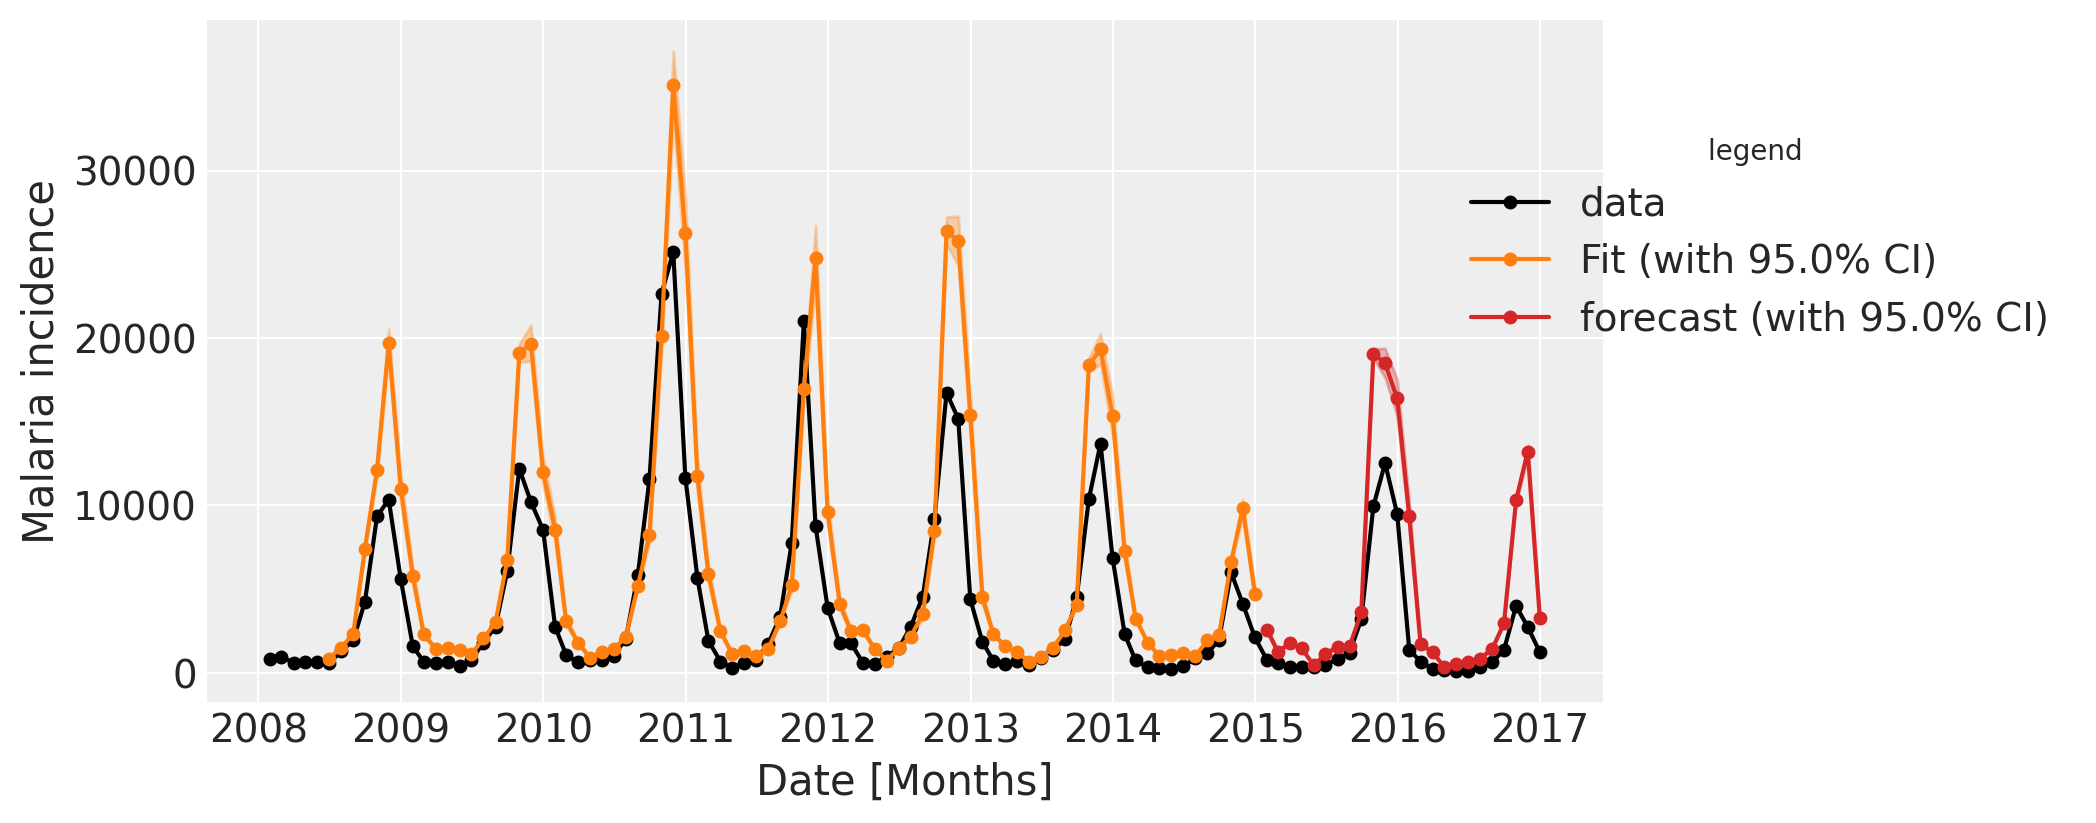

In [14]:
#************************ Dakar ******************************
#******************** We take into account the lag *************************
t_s=0;t_i=5; t_c=84; t_e=108; intercept=np.ones(t_e) 
X = np.c_[df.Rainfall, AVT_Dakar, df.Humidity_D, df.MC_Dakar, intercept]
y_o=df.MC_Dakar.values; lag=[2,2,5,1] 
y_train=y_o[t_i:t_c] ; y_test=y_o[t_c:t_e]
X_train = np.c_[X[t_i-lag[0]:t_c-lag[0],0], X[t_i-lag[1]:t_c-lag[1],1], X[t_i-lag[2]:t_c-lag[2],2], X[t_i-lag[3]:t_c-lag[3],3], X[t_i:t_c,4]]
X_test = np.c_[X[t_c-lag[0]:t_e-lag[0],0], X[t_c-lag[1]:t_e-lag[1],1], X[t_c-lag[2]:t_e-lag[2],2], X[t_c-lag[3]:t_e-lag[3],3], X[t_c:t_e,4]]
model = sm.GLM(y_train, X_train, family=Poisson(link=identity)).fit()     
ecart_type = np.sqrt(np.diag(model.cov_params()))
# True parameter values
alpha = model.params[4];   beta = [model.params[0], model.params[1], model.params[2], model.params[3]]
# Predictor variable
X0 = X_train[:,0]; X1 = X_train[:,1]; X2 = X_train[:,2]; X3 = X_train[:,3]
# Simulate outcome variable
Y = alpha + beta[0] * X0 + beta[1] * X1 + beta[2] * X2 + beta[3] * X3
basic_model = pm.Model()
with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=model.params[4], sigma=ecart_type[4]**2)
    beta[0] = pm.Normal("beta[0]", mu=model.params[0], sigma=ecart_type[0]**2) #np.abs(model.params[0])**2
    beta[1] = pm.Normal("beta[1]", mu=model.params[1], sigma=ecart_type[1]**2)
    beta[2] = pm.Normal("beta[2]", mu=model.params[2], sigma=ecart_type[2]**2)
    beta[3] = pm.Normal("beta[3]", mu=model.params[3], sigma=ecart_type[3]**2)
    #****  Deterministic model of the expected and the forecasted value of outcome
    mu = alpha + beta[0] * X0 + beta[1] * X1 + beta[2] * X2 + beta[3] * X3
    #*****Posterior distribution   
    pm.Deterministic('mu', mu)

    forecasts = beta[0]*X_test[:,0] + beta[1] * X_test[:,1] + beta[2] * X_test[:,2] + beta[3] * X_test[:,3] + alpha
    #forecasts =pm.StudentT("obss",nu=4, mu=forecasts, sigma=forecasts ** 0.5 ,observed=y_test)
    pm.Deterministic('forecasts', forecasts)
    #****we use Powell’s method to find the MAP
    map_estimate = pm.find_MAP(model=basic_model, method="powell")
    #print(sw_regions, sw_model, map_estimate)
    #*******posterior samples
    trace = pm.sample(draws=500,tune=170)  #
    #trace["alpha"] #We can see the  values for the alpha variable as follows:
    q_1 =2.5; q_3 =97.5
    fig=plt.figure(figsize=(8,4))
    plt.plot(df.Date, y_o, label='data',color = "black" , marker='o', markersize=4)
    percentiles = np.percentile(trace.mu, q_1, axis=0), np.percentile(trace.mu, q_3, axis=0)
    percentiles_forecasts = np.percentile(trace.forecasts, q_1, axis=0), np.percentile(trace.forecasts, q_3, axis=0)
    plt.plot(df.Date[t_i:t_c], np.median(trace.mu, axis=0),color='tab:orange', label='Fit (with '+str(q_3 - q_1) + '% CI)',  marker='o', markersize=4)
    plt.plot(df.Date[t_c:t_e], np.median(trace.forecasts, axis=0),color='tab:red', label='forecast (with '+str(q_3 - q_1) + '% CI)',  marker='o', markersize=4)
    plt.fill_between(df.Date[t_i:t_c], percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')
    plt.fill_between(df.Date[t_c:t_e], percentiles_forecasts[0], percentiles_forecasts[1], alpha=0.3, color='tab:red')
    #plt.yscale('log')
    plt.ylabel('Malaria incidence')
    plt.xlabel('Date [Months]')
    #plt.xticks(rotation=90)
    fig.legend(title="legend ",loc='upper center', bbox_to_anchor=(1.1, 0.9), shadow=True, ncol=1)
    plt.show()

ERROR:pymc3:There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 150 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


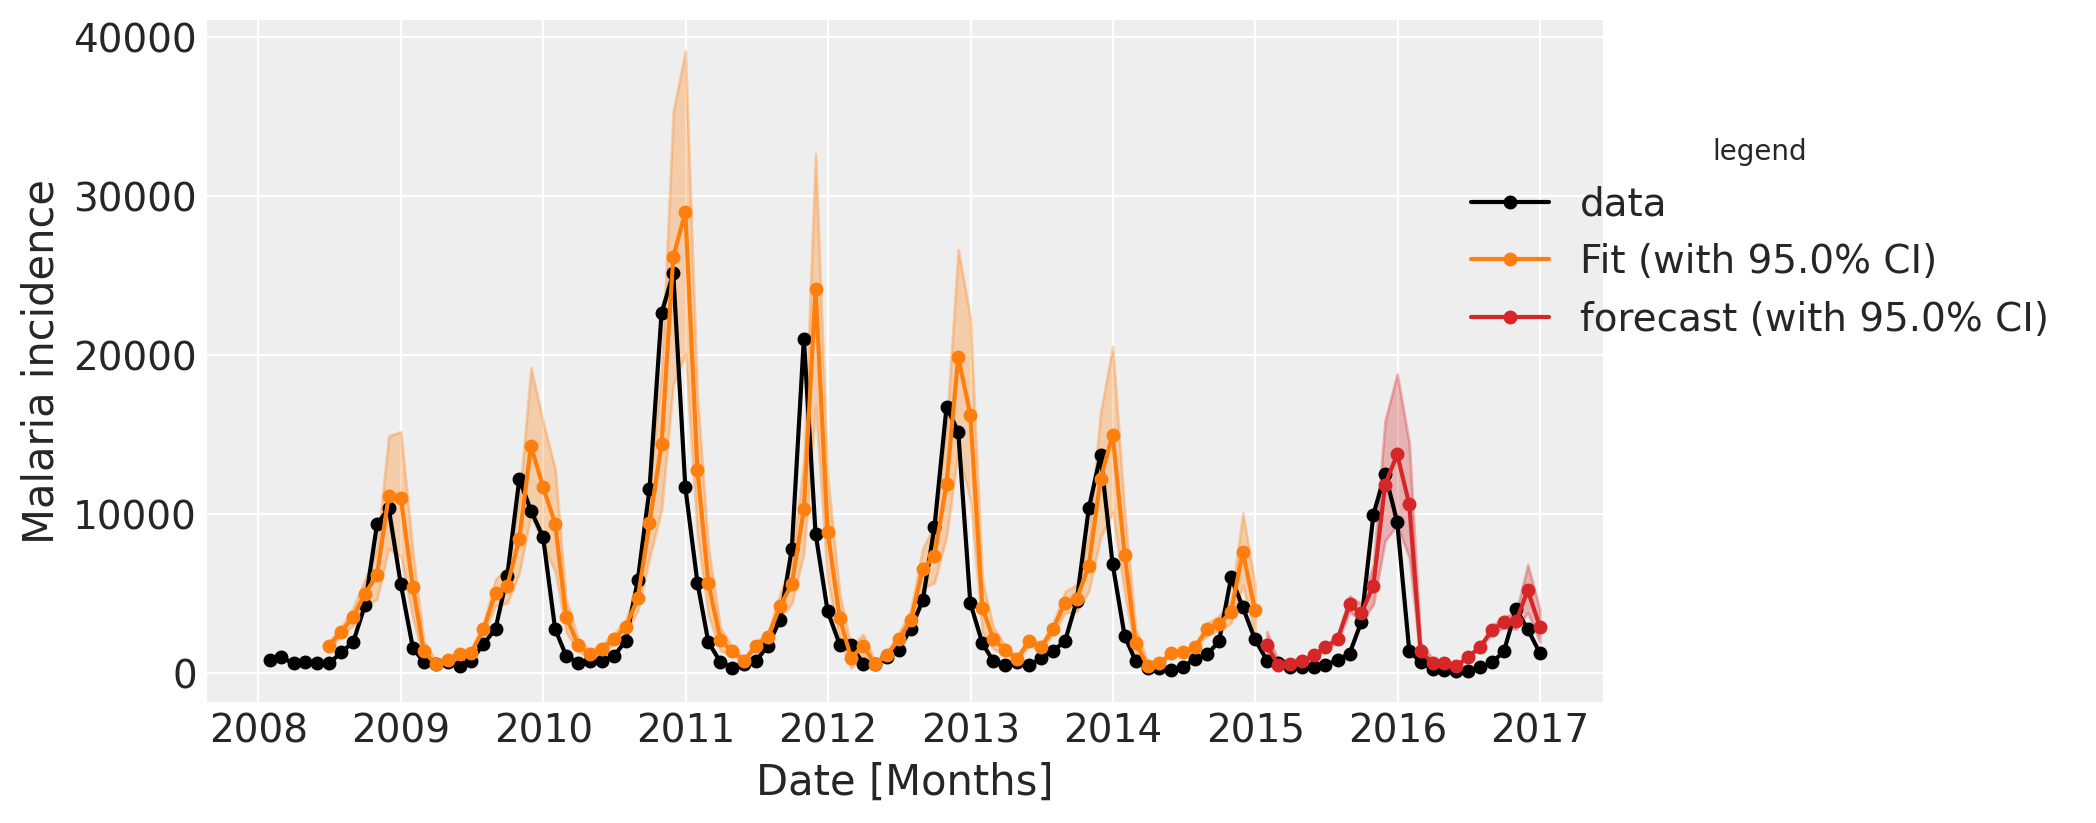

In [15]:
#************************ Dakar ******************************
#******************** We take into account the lag only in the past of malaria *************************
t_s=0;t_i=5; t_c=84; t_e=108; intercept=np.ones(t_e) 
X = np.c_[df.Rainfall, AVT_Dakar, df.Humidity_D, df.MC_Dakar, intercept]
y_o=df.MC_Dakar.values; lag=[2,2,5,1] 
y_train=y_o[t_i:t_c] ; y_test=y_o[t_c:t_e]
X_train = np.c_[X[t_i:t_c,0], X[t_i:t_c,1], X[t_i:t_c,2], X[t_i-lag[3]:t_c-lag[3],3], X[t_i:t_c,4]]
X_test = np.c_[X[t_c:t_e,0], X[t_c:t_e,1], X[t_c:t_e,2], X[t_c-lag[3]:t_e-lag[3],3], X[t_c:t_e,4]]
model = sm.GLM(y_train, X_train, family=Poisson(link=identity)).fit()     
ecart_type = np.sqrt(np.diag(model.cov_params()))
# True parameter values
alpha = model.params[4];   beta = [model.params[0], model.params[1], model.params[2], model.params[3]]
# Predictor variable
X0 = X_train[:,0]; X1 = X_train[:,1]; X2 = X_train[:,2]; X3 = X_train[:,3]
# Simulate outcome variable
Y = alpha + beta[0] * X0 + beta[1] * X1 + beta[2] * X2 + beta[3] * X3
basic_model = pm.Model()
with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=model.params[4], sigma=ecart_type[4]**2)
    beta[0] = pm.Normal("beta[0]", mu=model.params[0], sigma=ecart_type[0]**2) #np.abs(model.params[0])**2
    beta[1] = pm.Normal("beta[1]", mu=model.params[1], sigma=ecart_type[1]**2)
    beta[2] = pm.Normal("beta[2]", mu=model.params[2], sigma=ecart_type[2]**2)
    beta[3] = pm.Normal("beta[3]", mu=model.params[3], sigma=ecart_type[3]**2)
    #****  Deterministic model of the expected and the forecasted value of outcome
    mu = alpha + beta[0] * X0 + beta[1] * X1 + beta[2] * X2 + beta[3] * X3
    forecasts = beta[0]*X_test[:,0] + beta[1] * X_test[:,1] + beta[2] * X_test[:,2] + beta[3] * X_test[:,3] + alpha
    #*****Posterior distribution   
    pm.Deterministic('mu', mu)
    #forecasts =pm.StudentT("obss",nu=4, mu=forecasts,sigma=forecasts ** 0.5 ,observed=y_test)
    pm.Deterministic('forecasts', forecasts)
    #****we use Powell’s method to find the MAP
    map_estimate = pm.find_MAP(model=basic_model, method="powell")
    #print(sw_regions, sw_model, map_estimate)
    #*******posterior samples
    trace = pm.sample(draws=500,tune=250)  #
    #trace["alpha"] #We can see the  values for the alpha variable as follows:
    q_1 =2.5; q_3 =97.5
    fig=plt.figure(figsize=(8,4))
    plt.plot(df.Date, y_o, label='data',color = "black" , marker='o', markersize=4)
    percentiles = np.percentile(trace.mu, q_1, axis=0), np.percentile(trace.mu, q_3, axis=0)
    percentiles_forecasts = np.percentile(trace.forecasts, q_1, axis=0), np.percentile(trace.forecasts, q_3, axis=0)
    plt.plot(df.Date[t_i:t_c], np.median(trace.mu, axis=0),color='tab:orange', label='Fit (with '+str(q_3 - q_1) + '% CI)',  marker='o', markersize=4)
    plt.plot(df.Date[t_c:t_e], np.median(trace.forecasts, axis=0),color='tab:red', label='forecast (with '+str(q_3 - q_1) + '% CI)',  marker='o', markersize=4)
    plt.fill_between(df.Date[t_i:t_c], percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')
    plt.fill_between(df.Date[t_c:t_e], percentiles_forecasts[0], percentiles_forecasts[1], alpha=0.3, color='tab:red')
    #plt.yscale('log')
    plt.ylabel('Malaria incidence')
    plt.xlabel('Date [Months]')
    #plt.xticks(rotation=90)
    fig.legend(title="legend",loc='upper center', bbox_to_anchor=(1.1, 0.9), shadow=True, ncol=1)
    plt.show()

ERROR:pymc3:There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 260 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


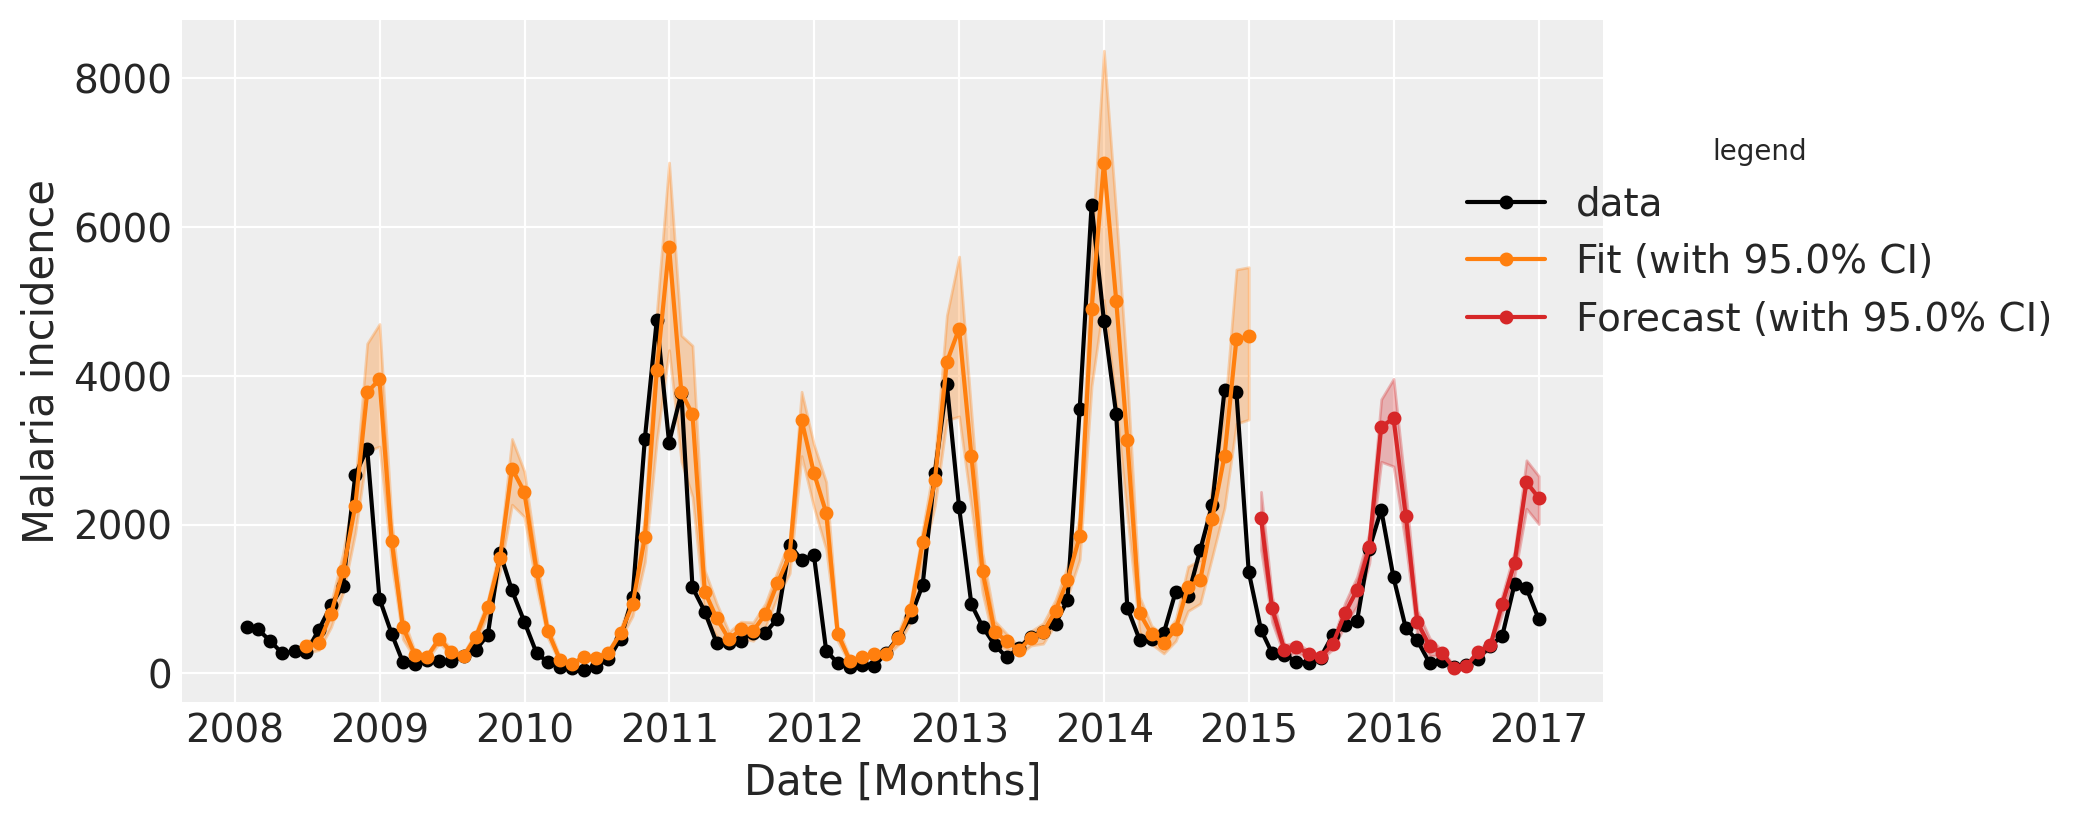

In [16]:
#************************ Fatick ******************************
#We take into account the lag in all the explanatory variables
t_s=0;t_i=5; t_c=84; t_e=108; intercept=np.ones(t_e) 
X = np.c_[df.Rainfall_F, AVT_Fatick, df.Humidity_F, df.MC_Fatick, intercept]
y_o=df.MC_Fatick.values; lag=[3,4,3,1] 
y_train=y_o[t_i:t_c] ; y_test=y_o[t_c:t_e]
X_train = np.c_[X[t_i-lag[0]:t_c-lag[0],0], X[t_i-lag[1]:t_c-lag[1],1], X[t_i-lag[2]:t_c-lag[2],2], X[t_i-lag[3]:t_c-lag[3],3], X[t_i:t_c,4]]
X_test = np.c_[X[t_c-lag[0]:t_e-lag[0],0], X[t_c-lag[1]:t_e-lag[1],1], X[t_c-lag[2]:t_e-lag[2],2], X[t_c-lag[3]:t_e-lag[3],3], X[t_c:t_e,4]]
model = sm.GLM(y_train, X_train, family=Poisson(link=identity)).fit()     
ecart_type = np.sqrt(np.diag(model.cov_params()))
# True parameter values
alpha = model.params[4]
beta = [model.params[0], model.params[1], model.params[2], model.params[3]]
# Predictor variable
X0 = X_train[:,0]; X1 = X_train[:,1]; X2 = X_train[:,2]; X3 = X_train[:,3]
# Simulate outcome variable
Y = alpha + beta[0] * X0 + beta[1] * X1 + beta[2] * X2 + beta[3] * X3
basic_model = pm.Model()
with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=model.params[4], sigma=ecart_type[4]**2)
    beta[0] = pm.Normal("beta[0]", mu=model.params[0], sigma=ecart_type[0]**2) #np.abs(model.params[0])**2
    beta[1] = pm.Normal("beta[1]", mu=model.params[1], sigma=ecart_type[1]**2)
    beta[2] = pm.Normal("beta[2]", mu=model.params[2], sigma=ecart_type[2]**2)
    beta[3] = pm.Normal("beta[3]", mu=model.params[3], sigma=ecart_type[3]**2)
    #****  Deterministic model of the expected and the forecasted value of outcome
    mu = alpha + beta[0] * X0 + beta[1] * X1 + beta[2] * X2 + beta[3] * X3
    forecasts = beta[0]*X_test[:,0] + beta[1] * X_test[:,1] + beta[2] * X_test[:,2] + beta[3] * X_test[:,3] + alpha 
    pm.Deterministic('mu', mu)
    #forecasts =pm.StudentT("obss",nu=4, mu=forecasts,sigma=forecasts ** 0.5 ,observed=y_test)
    pm.Deterministic('forecasts', forecasts)
    #****we use Powell’s method to find the MAP
    map_estimate = pm.find_MAP(model=basic_model, method="powell")
    #print(sw_regions, sw_model, map_estimate)
    #*******posterior samples
    trace = pm.sample(draws=500,tune=300)  #
    #trace["alpha"] #We can see the  values for the alpha variable as follows:
    q_1 =2.5; q_3 =97.5
    fig=plt.figure(figsize=(8,4))
    plt.plot(df.Date, y_o, label='data',color = "black" , marker='o', markersize=4)
    percentiles = np.percentile(trace.mu, q_1, axis=0), np.percentile(trace.mu, q_3, axis=0)
    percentiles_forecasts = np.percentile(trace.forecasts, q_1, axis=0), np.percentile(trace.forecasts, q_3, axis=0)
    plt.plot(df.Date[t_i:t_c], np.median(trace.mu, axis=0),color='tab:orange', label='Fit (with '+str(q_3 - q_1) + '% CI)',  marker='o', markersize=4)
    plt.plot(df.Date[t_c:t_e], np.median(trace.forecasts, axis=0),color='tab:red', label='Forecast (with '+str(q_3 - q_1) + '% CI)',  marker='o', markersize=4)
    #print(percentiles)
    plt.fill_between(df.Date[t_i:t_c], percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')
    plt.fill_between(df.Date[t_c:t_e], percentiles_forecasts[0], percentiles_forecasts[1], alpha=0.3, color='tab:red')
    #plt.yscale('log')
    plt.ylabel('Malaria incidence')
    plt.xlabel('Date [Months]')
    #plt.xticks(rotation=90)
    fig.legend(title="legend",loc='upper center', bbox_to_anchor=(1.1, 0.9), shadow=True, ncol=1)
    plt.show()

ERROR:pymc3:There were 220 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 404 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


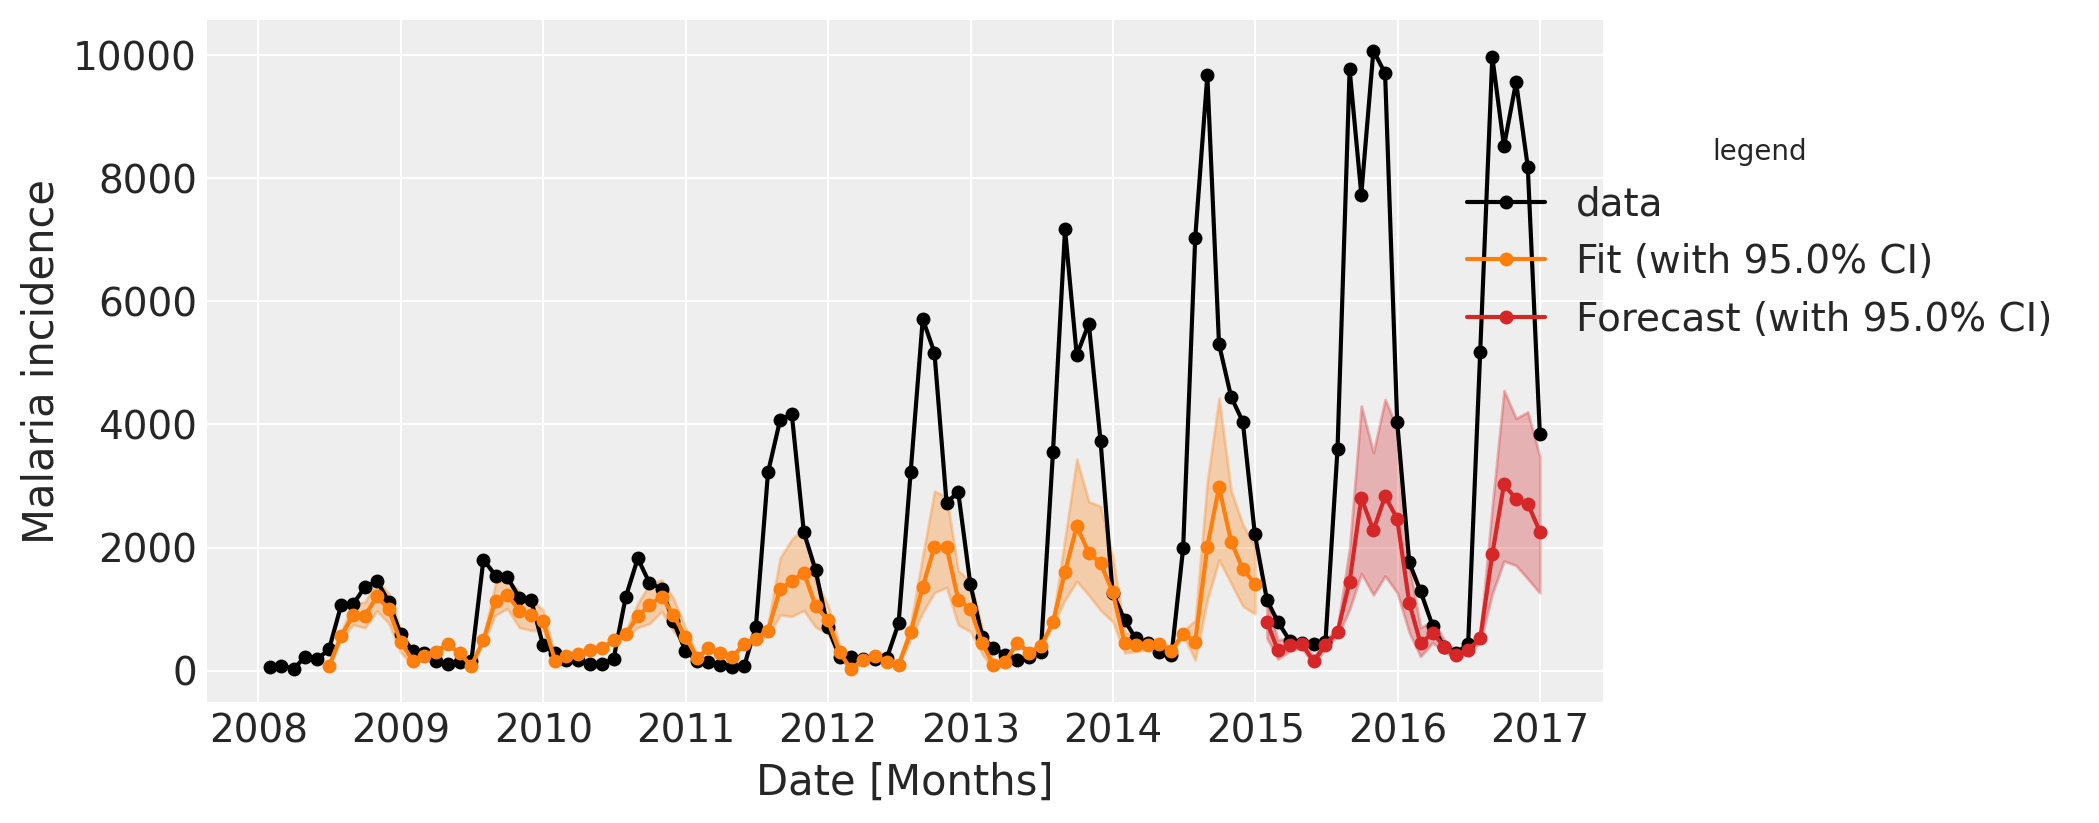

In [17]:
#************************ Kedougou ******************************
#We make that for all the regions
t_s=0;t_i=5; t_c=84; t_e=108; intercept=np.ones(t_e) 
X = np.c_[df.Rainfall_K, AVT_Kedougou, df.Humidity_K, df.MC_Kedougou, intercept]; y_o=df.MC_Kedougou.values; lag=[2,5,2,1]
y_train=y_o[t_i:t_c] ; y_test=y_o[t_c:t_e]
X_train = np.c_[X[t_i-lag[0]:t_c-lag[0],0], X[t_i-lag[1]:t_c-lag[1],1], X[t_i-lag[2]:t_c-lag[2],2], X[t_i-lag[3]:t_c-lag[3],3], X[t_i:t_c,4]]
X_test = np.c_[X[t_c-lag[0]:t_e-lag[0],0], X[t_c-lag[1]:t_e-lag[1],1], X[t_c-lag[2]:t_e-lag[2],2], X[t_c-lag[3]:t_e-lag[3],3], X[t_c:t_e,4]]
model = sm.GLM(y_train, X_train, family=Poisson(link=identity)).fit()     
ecart_type = np.sqrt(np.diag(model.cov_params()))
# True parameter values
alpha = model.params[4]
beta = [model.params[0], model.params[1], model.params[2], model.params[3]]
# Predictor variable
X0 = X_train[:,0]; X1 = X_train[:,1]; X2 = X_train[:,2]; X3 = X_train[:,3]
# Simulate outcome variable
Y = alpha + beta[0] * X0 + beta[1] * X1 + beta[2] * X2 + beta[3] * X3
basic_model = pm.Model()
with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=model.params[4], sigma=ecart_type[4]**2)
    beta[0] = pm.Normal("beta[0]", mu=model.params[0], sigma=ecart_type[0]**2) #np.abs(model.params[0])**2
    beta[1] = pm.Normal("beta[1]", mu=model.params[1], sigma=ecart_type[1]**2)
    beta[2] = pm.Normal("beta[2]", mu=model.params[2], sigma=ecart_type[2]**2)
    beta[3] = pm.Normal("beta[3]", mu=model.params[3], sigma=ecart_type[3]**2)
    #****  Deterministic model of the expected and the forecasted value of outcome
    mu = alpha + beta[0] * X0 + beta[1] * X1 + beta[2] * X2 + beta[3] * X3
    forecasts = beta[0]*X_test[:,0] + beta[1] * X_test[:,1] + beta[2] * X_test[:,2] + beta[3] * X_test[:,3] + alpha 
    pm.Deterministic('mu', mu)
    pm.Deterministic('forecasts', forecasts)
    #****we use Powell’s method to find the MAP
    map_estimate = pm.find_MAP(model=basic_model, method="powell")
    #*******posterior samples
    trace = pm.sample(draws=500,tune=300)  #
    #trace["alpha"] #We can see the  values for the alpha variable as follows:
    q_1 =2.5; q_3 =97.5
    fig=plt.figure(figsize=(8,4))
    plt.plot(df.Date, y_o, label='data',color = "black" , marker='o', markersize=4)
    percentiles = np.percentile(trace.mu, q_1, axis=0), np.percentile(trace.mu, q_3, axis=0)
    percentiles_forecasts = np.percentile(trace.forecasts, q_1, axis=0), np.percentile(trace.forecasts, q_3, axis=0)
    plt.plot(df.Date[t_i:t_c], np.median(trace.mu, axis=0),color='tab:orange', label='Fit (with '+str(q_3 - q_1) + '% CI)',  marker='o', markersize=4)
    plt.plot(df.Date[t_c:t_e], np.median(trace.forecasts, axis=0),color='tab:red', label='Forecast (with '+str(q_3 - q_1) + '% CI)',  marker='o', markersize=4)
    #print(percentiles)
    plt.fill_between(df.Date[t_i:t_c], percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')
    plt.fill_between(df.Date[t_c:t_e], percentiles_forecasts[0], percentiles_forecasts[1], alpha=0.3, color='tab:red')
    plt.ylabel('Malaria incidence')
    plt.xlabel('Date [Months]')
    #plt.xticks(rotation=90)
    fig.legend(title="legend",loc='upper center', bbox_to_anchor=(1.1, 0.9), shadow=True, ncol=1)
    plt.show()

In [18]:
#We train the GLM models on a specific region and we make the forecasts with these coeff in the others regions
#We make that for all the regions
t_s=0;t_i=5; t_c=96; t_e=108; intercept=np.ones(t_e) ; regions = ['Dakar','Fatick','Kedougou'];  models = ['Poisson_algo1', 'Poisson_algo2'] 
for sw_regions in regions: 
    print("***************************",sw_regions, "******************************")
    print("***********************************************************************")
    if sw_regions=='Dakar':
        X = np.c_[df.Rainfall, AVT_Dakar, df.Humidity_D, df.MC_Dakar, intercept]
        y_o=df.MC_Dakar.values; lag=[2,2,5,1] 
    if sw_regions=='Fatick':
        X= np.c_[df.Rainfall_F, AVT_Fatick, df.Humidity_F, df.MC_Fatick, intercept]
        y_o=df.MC_Fatick.values; lag=[3,4,3,1] 
    if sw_regions=='Kedougou':
        X = np.c_[df.Rainfall_K, AVT_Kedougou, df.Humidity_K, df.MC_Kedougou, intercept]
        y_o=df.MC_Kedougou.values; lag=[2,5,2,1]

    y_train=y_o[t_i:t_c] ; y_test=y_o[t_c:t_e]
    X_train = np.c_[X[t_i-lag[0]:t_c-lag[0],0], X[t_i-lag[1]:t_c-lag[1],1], X[t_i-lag[2]:t_c-lag[2],2], X[t_i-lag[3]:t_c-lag[3],3], X[t_i:t_c,4]]
    X_test = np.c_[X[t_c-lag[0]:t_e-lag[0],0], X[t_c-lag[1]:t_e-lag[1],1], X[t_c-lag[2]:t_e-lag[2],2], X[t_c-lag[3]:t_e-lag[3],3], X[t_c:t_e,4]]
    model = sm.GLM(y_train, X_train, family=Poisson(link=identity)).fit()
    #print(model.summary2())      
    print(np.sqrt(np.diag(model.cov_params()))) #to get the Std.erro
    ecart_type = np.sqrt(np.diag(model.cov_params()))
    # True parameter values
    alpha = model.params[4]
    beta = [model.params[0], model.params[1], model.params[2], model.params[3]]
    # Predictor variable
    X0 = X_train[:,0]
    X1 = X_train[:,1]
    X2 = X_train[:,2]
    X3 = X_train[:,3]
    # Simulate outcome variable
    Y = alpha + beta[0] * X0 + beta[1] * X1 + beta[2] * X2 + beta[3] * X3
    basic_model = pm.Model()
    with basic_model:
        # Priors for unknown model parameters
        alpha = pm.Normal("alpha", mu=model.params[4], sigma=ecart_type[4]**2)
        beta[0] = pm.Normal("beta[0]", mu=model.params[0], sigma=ecart_type[0]**2) #np.abs(model.params[0])**2
        beta[1] = pm.Normal("beta[1]", mu=model.params[1], sigma=ecart_type[1]**2)
        beta[2] = pm.Normal("beta[2]", mu=model.params[2], sigma=ecart_type[2]**2)
        beta[3] = pm.Normal("beta[3]", mu=model.params[3], sigma=ecart_type[3]**2)
        #****  Deterministic model of the expected and the forecasted value of outcome
        mu = alpha + beta[0] * X0 + beta[1] * X1 + beta[2] * X2 + beta[3] * X3
        forecasts = beta[0]*X_test[:,0] + beta[1] * X_test[:,1] + beta[2] * X_test[:,2] + beta[3] * X_test[:,3] + alpha
        #*****Posterior distribution
        # Likelihood (sampling distribution) of observations
        #**** observed cases are distributed following studentT or Poisson around the model
        #pm.StudentT("obs",nu=4,mu=mu,sigma=mu ** 0.5 ,observed=y_train) 
        #mu=pm.Poisson("obs", mu=mu, observed=y_train)   
        pm.Deterministic('mu', mu)
        #forecasts =pm.StudentT("obss",nu=4, mu=forecasts,sigma=forecasts ** 0.5 ,observed=y_test)
        pm.Deterministic('forecasts', forecasts)
    #*****Maximum a posteriori methods: By default, find_MAP uses the Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimization algorithm 
    #map_estimate = pm.find_MAP(model=basic_model)
    #print(sw_regions, sw_model, map_estimate)
    #****we use Powell’s method to find the MAP
    #map_estimate = pm.find_MAP(model=basic_model, method="powell")
    #print(sw_regions, sw_model, map_estimate)
    #Sampling methods
    with basic_model:
        # draw 500 posterior samples
        trace = pm.sample(draws=1000,tune=350, init="advi+adapt_diag")  #
        #trace["alpha"] #We can see the  values for the alpha variable as follows:
        
        fig=plt.figure(figsize=(8,4))
        plt.plot(df.Date, y_o, label='data',color = "black" , marker='o', markersize=4)
        percentiles = np.percentile(trace.mu, q=2.5, axis=0), np.percentile(trace.mu, q=97.5, axis=0)
        percentiles_forecasts = np.percentile(trace.forecasts, q=2.5, axis=0), np.percentile(trace.forecasts, q=97.5, axis=0)
        plt.plot(df.Date[t_i:t_c], np.median(trace.mu, axis=0),color='tab:orange', label='Fit (with '+str(q_3 - q_1) + '% CI)',  marker='o', markersize=4)
        plt.plot(df.Date[t_c:t_e], np.median(trace.forecasts, axis=0),color='tab:red', label='forecast (with '+str(q_3 - q_1) + '% CI)',  marker='o', markersize=4)
        #print(percentiles)
        plt.fill_between(df.Date[t_i:t_c], percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')
        plt.fill_between(df.Date[t_c:t_e], percentiles_forecasts[0], percentiles_forecasts[1], alpha=0.3, color='tab:red')
        #plt.yscale('log')
        plt.ylabel('Malaria incidence')
        plt.xlabel('Date [Months]')
        #plt.xticks(rotation=90)
        plt.title(sw_regions)
        fig.legend(title="legend",loc='upper center', bbox_to_anchor=(1.1, 0.9), shadow=True, ncol=1)
        plt.show()

*************************** Dakar ******************************
***********************************************************************
[1.48938060e-01 2.79353037e+00 6.15099307e-01 2.34429178e-03
 5.17057222e+01]


KeyboardInterrupt: ignored

In [ ]:
t_s=0;t_i=5; t_c=84; t_e=108; intercept=np.ones(t_e) ; regions = ['Dakar','Fatick','Kedougou'];  models = ['Poisson_algo1', 'Poisson_algo2'] 
for sw_regions in regions: 
    print("***********************************************************************")
    print("***************************",sw_regions, "******************************")
    print("***********************************************************************")
    if sw_regions=='Dakar':
        X = np.c_[df.Rainfall, AVT_Dakar, df.Humidity_D, df.MC_Dakar, intercept]
        y_o=df.MC_Dakar.values; lag=[2,2,5,1] 
    if sw_regions=='Fatick':
        X= np.c_[df.Rainfall_F, AVT_Fatick, df.Humidity_F, df.MC_Fatick, intercept]
        y_o=df.MC_Fatick.values; lag=[3,4,3,1] 
    if sw_regions=='Kedougou':
        X = np.c_[df.Rainfall_K, AVT_Kedougou, df.Humidity_K, df.MC_Kedougou, intercept]
        y_o=df.MC_Kedougou.values; lag=[2,5,2,1]

    y_train=y_o[t_i:t_c] ; y_test=y_o[t_c:t_e]
    X_train = np.c_[X[t_i-lag[0]:t_c-lag[0],0], X[t_i-lag[1]:t_c-lag[1],1], X[t_i-lag[2]:t_c-lag[2],2], X[t_i-lag[3]:t_c-lag[3],3], X[t_i:t_c,4]]
    X_test = np.c_[X[t_c-lag[0]:t_e-lag[0],0], X[t_c-lag[1]:t_e-lag[1],1], X[t_c-lag[2]:t_e-lag[2],2], X[t_c-lag[3]:t_e-lag[3],3], X[t_c:t_e,4]]
    model = sm.GLM(y_train, X_train, family=Poisson(link=identity)).fit()     
    #print(np.sqrt(np.diag(model.cov_params()))) #to get the Std.erro
    ecart_type = np.sqrt(np.diag(model.cov_params()))
    alpha = model.params[4]
    beta = [model.params[0], model.params[1], model.params[2], model.params[3]]
    # Predictor variable
    X0 = X_train[:,0]
    X1 = X_train[:,1]
    X2 = X_train[:,2]
    X3 = X_train[:,3]
    # Simulate outcome variable
    Y = alpha + beta[0] * X0 + beta[1] * X1 + beta[2] * X2 + beta[3] * X3
    basic_model = pm.Model()
    with basic_model:
        # Priors for unknown model parameters
        alpha = pm.Normal("alpha", mu=model.params[4], sigma=ecart_type[4]**2)
        beta[0] = pm.Normal("beta[0]", mu=model.params[0], sigma=ecart_type[0]**2) 
        beta[1] = pm.Normal("beta[1]", mu=model.params[1], sigma=ecart_type[1]**2)
        beta[2] = pm.Normal("beta[2]", mu=model.params[2], sigma=ecart_type[2]**2)
        beta[3] = pm.Normal("beta[3]", mu=model.params[3], sigma=ecart_type[3]**2)
        #****  Deterministic model of the expected and the forecasted value of outcome
        mu = alpha + beta[0] * X0 + beta[1] * X1 + beta[2] * X2 + beta[3] * X3
        forecasts = beta[0]*X_test[:,0] + beta[1] * X_test[:,1] + beta[2] * X_test[:,2] + beta[3] * X_test[:,3] + alpha
        #*****Posterior distribution
        # Likelihood (sampling distribution) of observations
        #**** observed cases are distributed following studentT or Poisson around the model
        #pm.StudentT("obs",nu=4,mu=mu,sigma=mu ** 0.5 ,observed=y_train) 
        #mu=pm.Poisson("obs", mu=mu, observed=y_train)   
        pm.Deterministic('mu', mu)
        #forecasts =pm.StudentT("obss",nu=4, mu=forecasts,sigma=forecasts ** 0.5 ,observed=y_test)
        pm.Deterministic('forecasts', forecasts)
    with basic_model:
        trace = pm.sample(draws=500,tune=300, init="advi+adapt_diag")  #
        fig=plt.figure(figsize=(8,4))
        plt.plot(df.Date, y_o, label='data',color = "black" , marker='o', markersize=4)
        q_1=12.5; q_3=87.5
        percentiles = np.percentile(trace.mu, q_1, axis=0), np.percentile(trace.mu, q_3, axis=0)
        percentiles_forecasts = np.percentile(trace.forecasts, q_1, axis=0), np.percentile(trace.forecasts, q_3, axis=0)
        plt.plot(df.Date[t_i:t_c], np.median(trace.mu, axis=0),color='tab:orange', label='Fit (with '+str(q_3 - q_1) + '% CI)',  marker='o', markersize=4)
        plt.plot(df.Date[t_c:t_e], np.median(trace.forecasts, axis=0),color='tab:red', label='Forecast (with '+str(q_3 - q_1) + '% CI)',  marker='o', markersize=4)
        plt.fill_between(df.Date[t_i:t_c], percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')
        plt.fill_between(df.Date[t_c:t_e], percentiles_forecasts[0], percentiles_forecasts[1], alpha=0.3, color='tab:red')
        #plt.yscale('log')
        plt.ylabel('Malaria incidence')
        plt.xlabel('Date [Months]')
        #plt.xticks(rotation=90)
        plt.title(sw_regions)
        fig.legend(title="legend",loc='upper center', bbox_to_anchor=(1.1, 0.9), shadow=True, ncol=1)
        plt.show()